# Real Estate USA

**Environment setup**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import datasets

%matplotlib inline

**Importing dataset**

In [9]:
df = pd.read_csv('../data/realtor-data.csv')

In [10]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


**Data Cleaning**

In [12]:
df.dtypes

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

In [13]:
# Rewriting wrong date '3019-04-20 --> 2019-04-02'
bad_date_index = df[(df['prev_sold_date']=='3019-04-02')].index
df.loc[bad_date_index, 'prev_sold_date'] = '2019-04-02'

In [14]:
# Converting sold date to datetime
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'])

In [15]:
df.dtypes

brokered_by              float64
status                    object
price                    float64
bed                      float64
bath                     float64
acre_lot                 float64
street                   float64
city                      object
state                     object
zip_code                 float64
house_size               float64
prev_sold_date    datetime64[ns]
dtype: object

In [16]:
df.shape

(2226382, 12)

**Mising Values**

In [17]:
df.isna().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [18]:
df.isna().mean()*100

brokered_by        0.203604
status             0.000000
price              0.069215
bed               21.618797
bath              22.986666
acre_lot          14.624130
street             0.488056
city               0.063197
state              0.000359
zip_code           0.013430
house_size        25.533983
prev_sold_date    32.981627
dtype: float64

In [19]:
df['bed'] = pd.to_numeric(df['bed'], errors='coerce')

df['bed'] = df['bed'].fillna(df['bed'].median())
df['bath'] = df['bath'].fillna(df['bath'].median())
df['acre_lot'] = df['acre_lot'].fillna(df['acre_lot'].mean())
df['house_size'] = df['house_size'].fillna(df['house_size'].mean())

In [20]:
df.dropna(subset=['brokered_by', 'price', 'street', 'city', 'state', 'zip_code'], inplace=True)

In [21]:
df.isna().sum()

brokered_by            0
status                 0
price                  0
bed                    0
bath                   0
acre_lot               0
street                 0
city                   0
state                  0
zip_code               0
house_size             0
prev_sold_date    725581
dtype: int64

**Duplicates**

In [22]:
df.duplicated().sum()

24

In [23]:
df.drop_duplicates(inplace=True)

**Outliers**

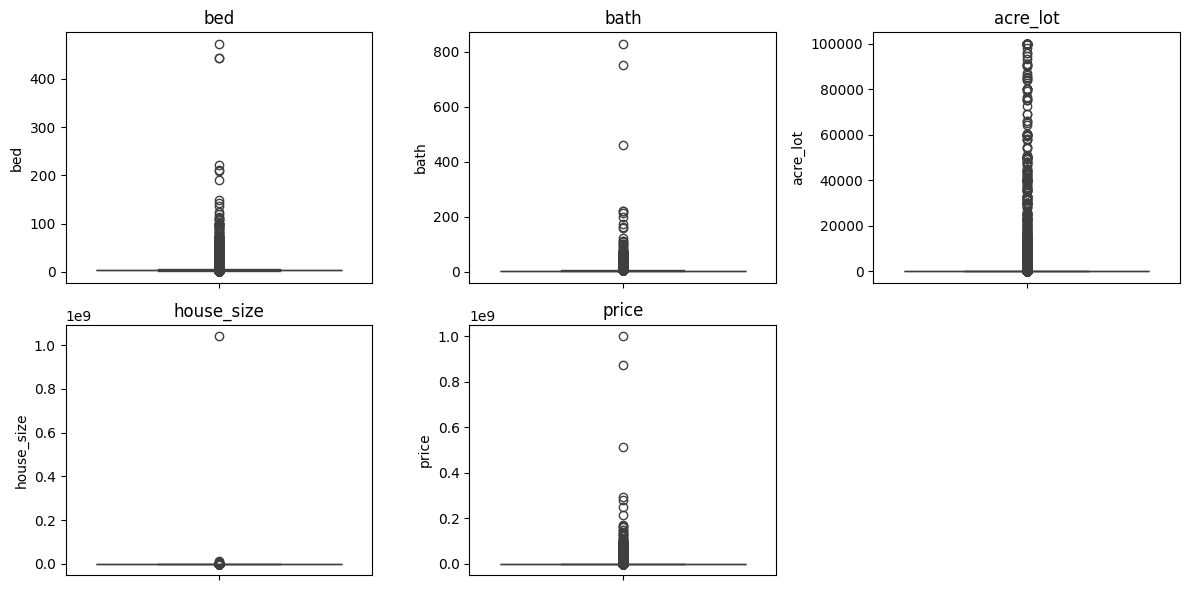

In [24]:
numerical_columns = ['bed', 'bath', 'acre_lot', 'house_size', 'price']

plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(col)
plt.tight_layout()
plt.show()

In [25]:
# Calculate z-scores for numerical columns
z_scores = stats.zscore(df[['bed', 'bath', 'acre_lot', 'house_size', 'price']])
abs_z_scores = np.abs(z_scores)

# Identify outliers based on z-score threshold
outliers = (abs_z_scores > 3).any(axis=1) 

# Filter DataFrame to include only rows with outliers
df_outliers = df[outliers]

# find percentage of outliers
percentage_of_outliers = (len(df_outliers) / len(df))
print(f"Proportion of outliers is approximately: {round(percentage_of_outliers, 3)}")

Proportion of outliers is approximately: 0.016


In [26]:
df.drop(df_outliers.index, inplace=True)

In [27]:
df = df[df['price'] <= 1e6]
df = df[df['house_size'] <= 0.003e6]

**Exploratory Analysis**

In [28]:
df_numerical = df[numerical_columns]

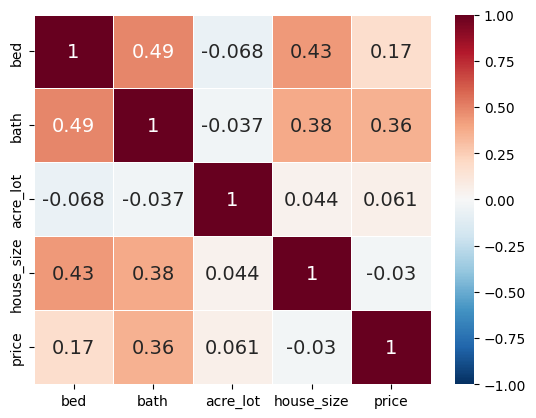

In [29]:
sns.heatmap(df_numerical.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":14}, cmap="RdBu_r", linewidths=0.5);

In [30]:
df.sort_values(['price'], ascending=False)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
2058680,84978.0,sold,1000000.0,3.0,3.0,0.210000,82223.0,Fullerton,California,92835.0,2280.0,2022-02-18
2070417,35346.0,sold,1000000.0,3.0,2.0,0.140000,1812278.0,Huntington Beach,California,92646.0,1176.0,2022-03-24
239450,14447.0,for_sale,1000000.0,3.0,3.0,15.223027,169193.0,Ocean City,Maryland,21842.0,1940.0,2013-06-28
2196414,44679.0,sold,1000000.0,3.0,3.0,0.130000,412855.0,Bothell,Washington,98012.0,2233.0,2022-03-11
1370029,10543.0,for_sale,1000000.0,3.0,2.0,3.660000,1469208.0,La Center,Washington,98629.0,1512.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
996678,46715.0,ready_to_build,0.0,3.0,2.0,15.223027,349755.0,Harrah,Oklahoma,73045.0,1965.0,NaT
1002306,71540.0,ready_to_build,0.0,4.0,2.0,15.223027,1842370.0,Haslet,Texas,76052.0,2819.0,NaT
372513,63715.0,ready_to_build,0.0,3.0,2.0,15.223027,1740028.0,Lawrenceville,Georgia,30043.0,1818.0,NaT
372512,63715.0,ready_to_build,0.0,3.0,2.0,15.223027,1740028.0,Lawrenceville,Georgia,30043.0,1829.0,NaT


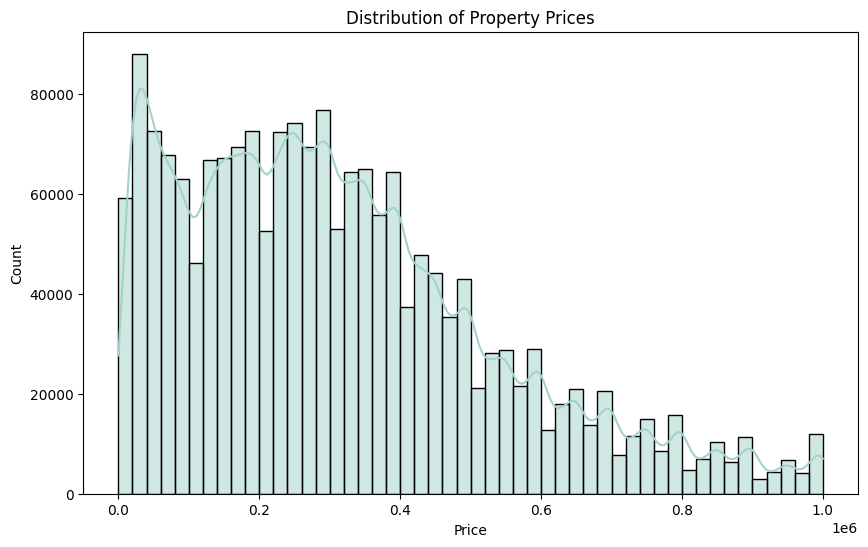

In [31]:
# Distribution of 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='#a3d2ca')
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

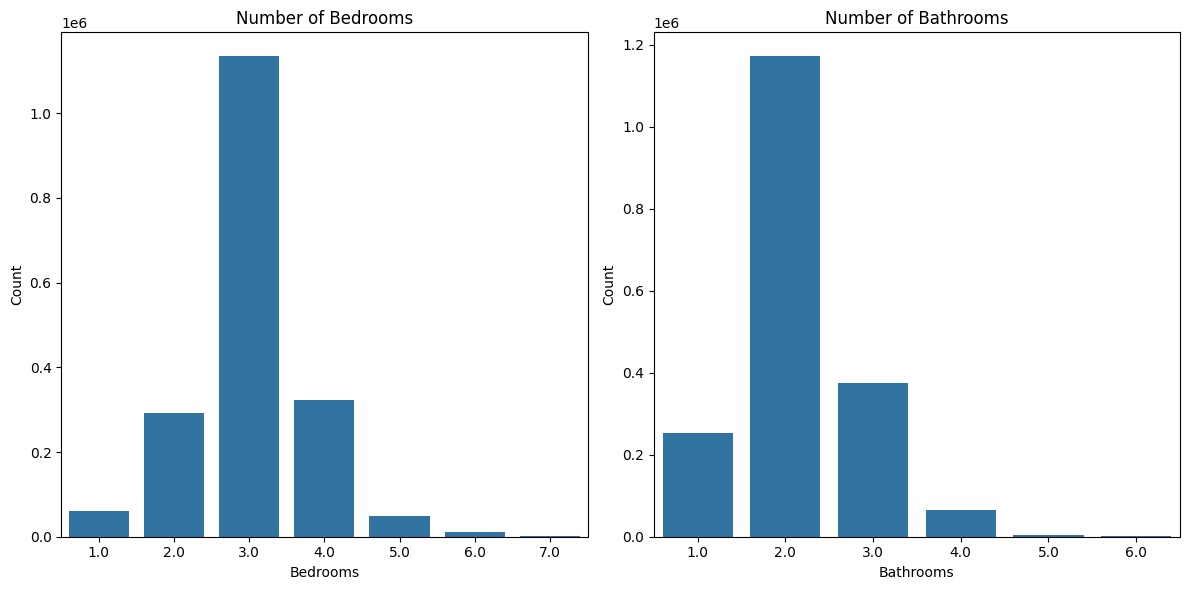

In [32]:
plt.figure(figsize=(12, 6))
# Plot number of bedrooms
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.countplot(data=df, x='bed')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')

# Plot number of bathrooms
plt.subplot(1, 2, 2)  # (rows, columns, index)
sns.countplot(data=df, x='bath')
plt.title('Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [33]:
top_10_cities=df['city'].value_counts().head(10)
top_10_states=df['state'].value_counts().head(10)

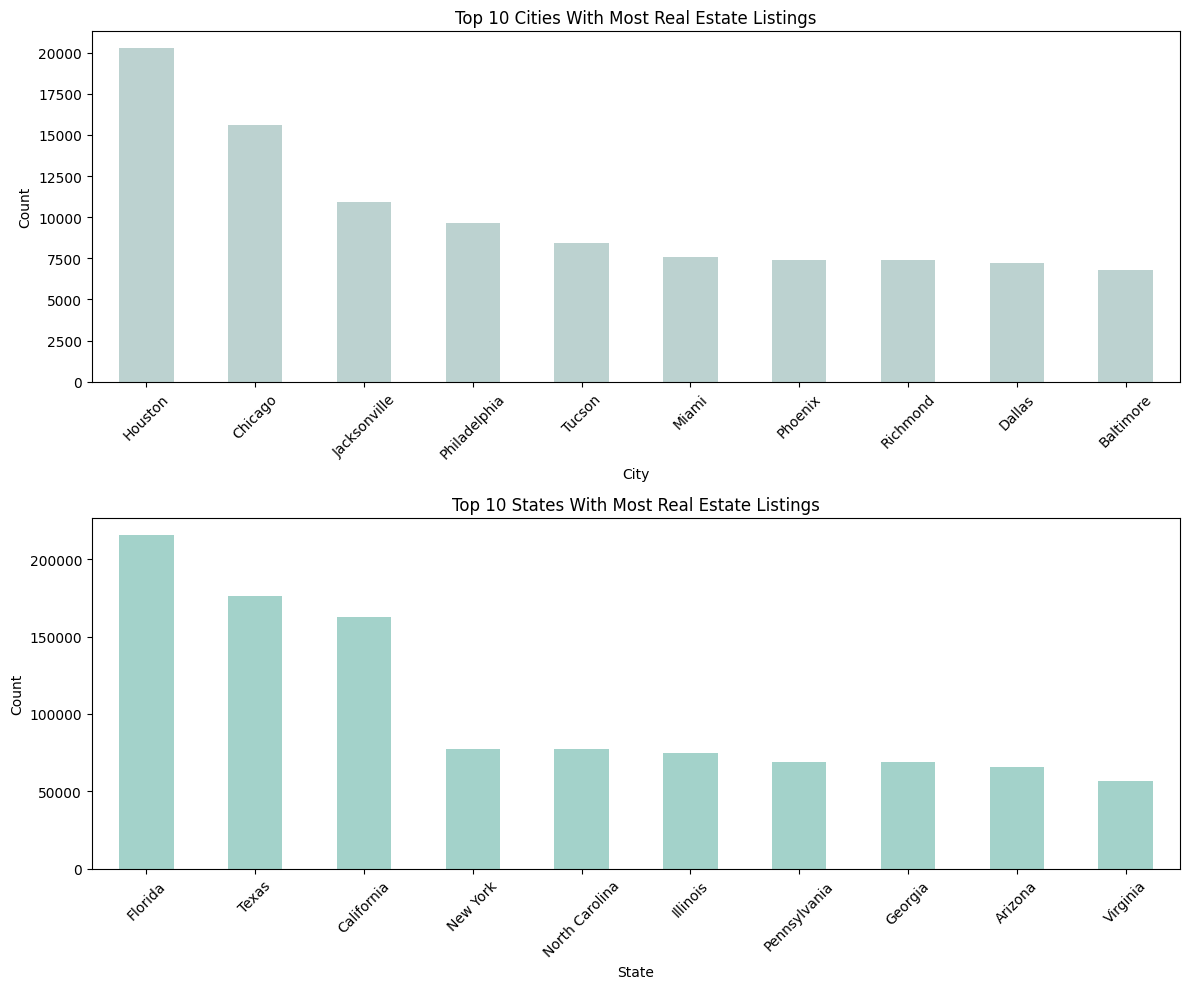

In [34]:
plt.figure(figsize=(12, 10))

# Plot the top 10 cities
plt.subplot(2, 1, 1)  # (rows, columns, index)
top_10_cities.plot(kind='bar', color='#bcd2d0')
plt.title('Top 10 Cities With Most Real Estate Listings')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot the top 10 states
plt.subplot(2, 1, 2)  # (rows, columns, index)
top_10_states.plot(kind='bar', color='#a3d2ca')
plt.title('Top 10 States With Most Real Estate Listings')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

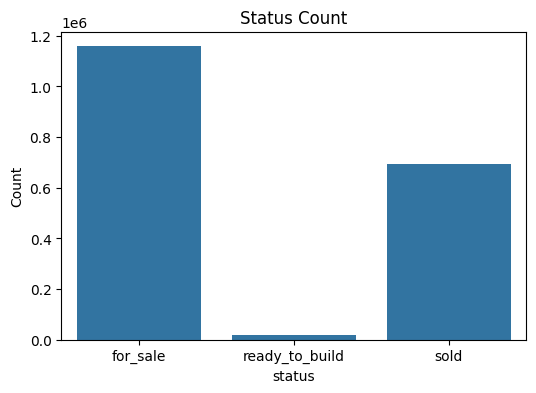

In [35]:
plt.figure(figsize=(6, 4))

sns.countplot(data = df, x='status')
plt.ylabel("Count")
plt.title('Status Count')
plt.show()

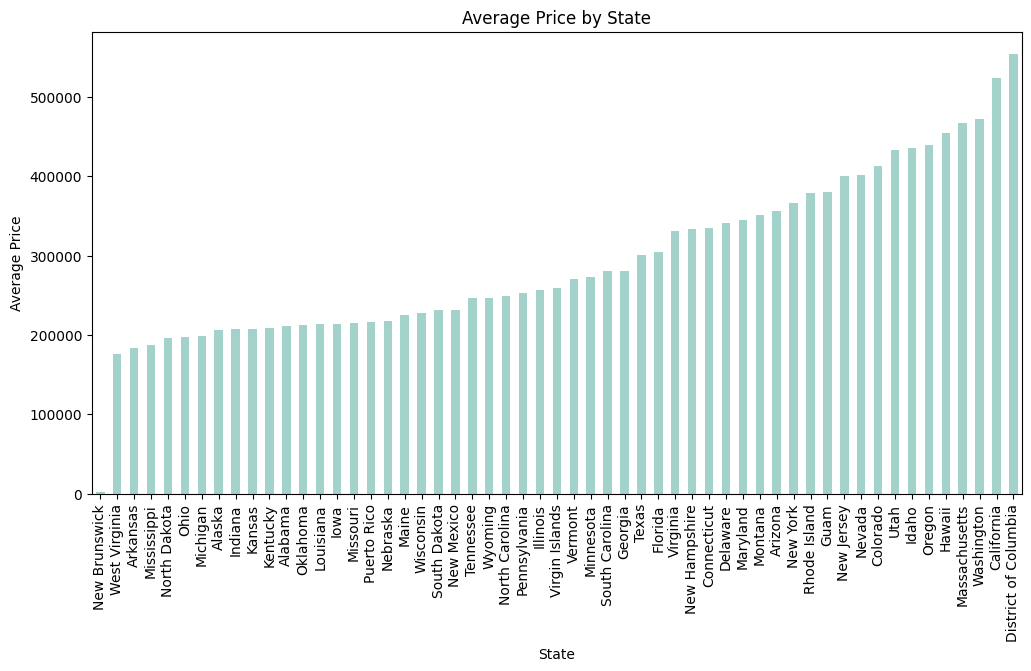

In [36]:
average_price_per_state = df.groupby('state')['price'].mean().sort_values()

plt.figure(figsize=(12, 6))
average_price_per_state.plot(kind='bar', color='#a3d2ca')
plt.title('Average Price by State')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

In [37]:
average_price_per_city = df.groupby('city')['price'].mean().sort_values()
top_50_expensive_cities = average_price_per_city.tail(50)

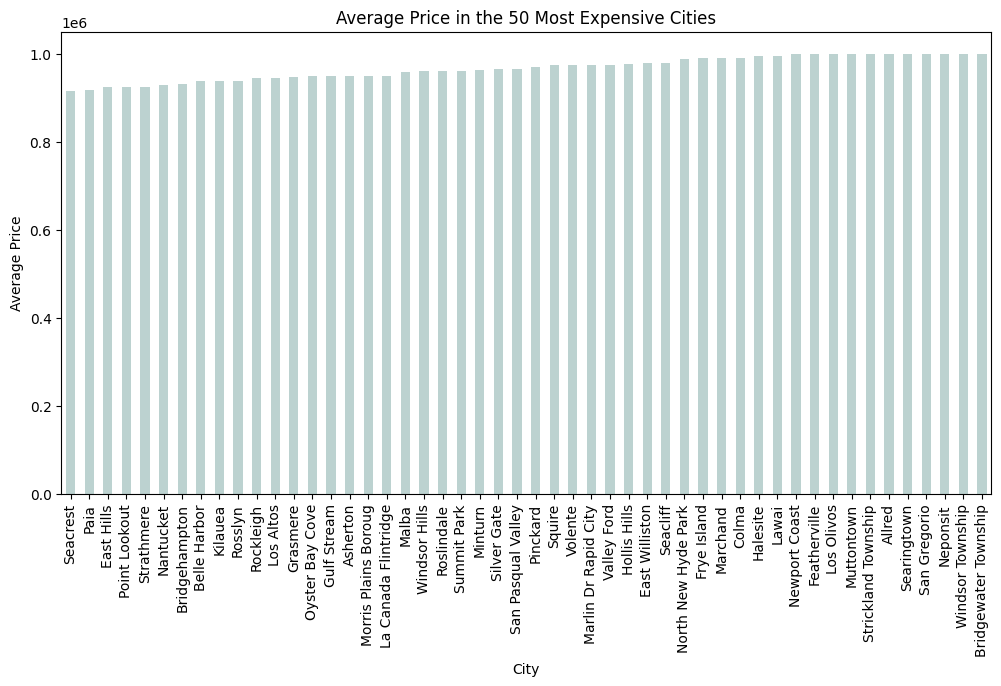

In [38]:
plt.figure(figsize=(12, 6))
top_50_expensive_cities.plot(kind='bar', color='#bcd2d0')
plt.title('Average Price in the 50 Most Expensive Cities')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

**Linear Regression**

In [39]:
# Selecting predictors and target variable
X = df[['bed', 'bath', 'acre_lot', 'house_size']]
y = df['price']

In [40]:
# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
# Coefficients (slopes) and Intercept
intercept = model.intercept_
coefficients = model.coef_

# Assuming X_test.columns contains the feature names
feature_names = X_test.columns

print("Intercept:", intercept)
print("\nCoefficient Interpretation:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: Each unit change increases the predicted price by ${coef:.2f}")

Intercept: 109887.34742502935

Coefficient Interpretation:
bed: Each unit change increases the predicted price by $20083.19
bath: Each unit change increases the predicted price by $131487.71
acre_lot: Each unit change increases the predicted price by $892.12
house_size: Each unit change increases the predicted price by $-72.66


In [43]:
# Predicting on test data
y_pred = model.predict(X_test)

In [45]:
# Model evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared (R^2): {r2:.2f}")
print("Root Mean Squared Error:", rmse)
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")


R-squared (R^2): 0.17
Root Mean Squared Error: 203532.53612459562
Mean Absolute Error (MAE): $158815.95
Mean Squared Error (MSE): $41425493261.31
Root Mean Squared Error (RMSE): $203532.54


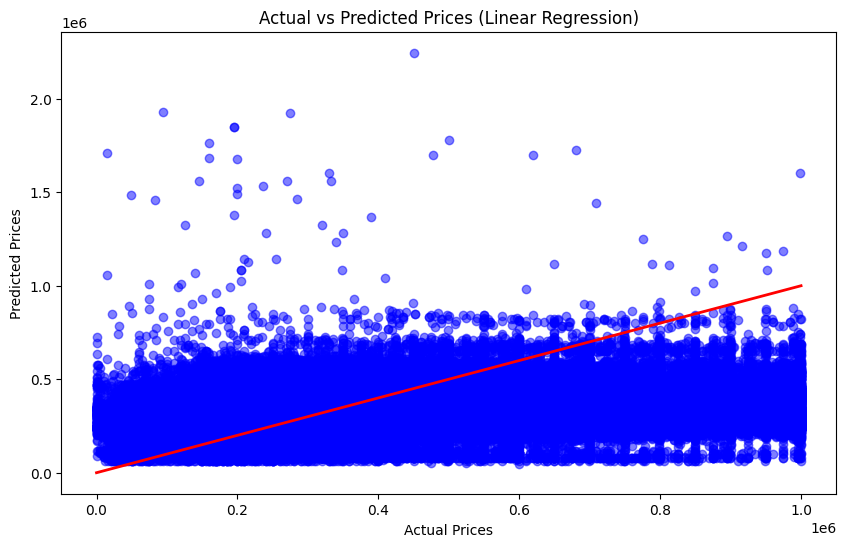

Bad pipe message: %s [b'0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nHost: localhost:32769\r\nUs', b'-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.']
Bad pipe message: %s [b'0.0 Safari/537.36\r\nAccept-Encoding: gzip, defla']
Bad pipe message: %s [b', br, zstd\r\nAccept-Language: en-US,en;q=0.9\r\nCache-Control: max-age=0\r\nReferer: https://github.com/\r\nX-Request-ID: ', b'd2b062decec9597668aed1deebd97e\r\nX-Real-IP: 10.240.2.99\r\nX-Forwarded-Port: 443\r\nX-Forwarded-Scheme:']
Bad pipe message: %s [b'ttps\r\nX-Original-URI: /\r\nX-Sche']
Bad pipe message: %s [b': https\r\nsec-fetch-site: cross-site\r\nsec-fetch-mode: navigate\r\nsec-fetch-dest: document\r\nsec-ch-ua: "Google ', b'rome";v="125", "Chromium";v="125", "Not.A/Brand";v="24"\r\nsec-ch-ua']
Bad pipe message: %s [b'obile: ?0\r\nsec-ch-ua-platform: "Windows"\r\npr', b'rity: u=0, i\r\nX-Original-Proto: https\r\nX-Forwarded-Proto: 

In [46]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='-', color='red', linewidth=2)
plt.title('Actual vs Predicted Prices (Linear Regression)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()